In [1]:
import pandas as pd
import numpy as np
import re


from tqdm import tqdm_notebook
import os
import csv

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


import requests
from bs4 import BeautifulSoup


In [2]:
soup = BeautifulSoup(open("IDEAS_query.html",encoding='utf-8'))#'https://ideas.repec.org/i/a.html'
tables = soup.find_all('table', attrs={'class':'table table-condensed table-striped'})

In [3]:
data_list = []
for table in tables:
    data = []
    for row in table.find_all('tr'):
        row_data = []
        for td in row.find_all('td'):
            td_check = td.find('a')
            if td_check is not None:
                link = td.a['href']
                row_data.append(link)
            if td_check is None:
                row_data.append(None)                
            not_link = ''.join(td.stripped_strings)
            if not_link == '':
                 not_link = None
            row_data.append(not_link)
        data.append(row_data)
    data_list.append(pd.DataFrame(data[1:]))#, columns=column_names)
    
#https://stackoverflow.com/questions/42285417/how-to-preserve-links-when-scraping-a-table-with-beautiful-soup-and-pandas

In [4]:
df = pd.concat(data_list).reset_index(drop=True)
df.columns=["publisher_link","publisher","journal_link","journal","count_link","count","date_link","date"]
df = df.dropna(axis=1,how='all')
display(df)

,publisher_link,publisher,journal_link,journal,count,date
0,https://journal.eae.com.ua,"""European Association of Economists""",/s/efn/journl.html,European scientific journal of Economic and Fi...,2 (2),2018-2018
1,https://www.ajol.info/index.php/ajer/index,African Journal of Economic Review,/s/ags/afjecr.html,African Journal of Economic Review,118 (118),2013-2019
2,http://afjrd.org/jos/index.php/afjrd/index,AFrican Journal of Rural Development (AFJRD),/s/ags/afjrde.html,African Journal of Rural Development (AFJRD),81 (81),2016-2018
3,http://are-journal.com/are,Agricultural and Resource Economics: Internati...,/s/ags/areint.html,Agricultural and Resource Economics: Internati...,171 (171),2015-2019
4,None,Ali Ã‡aÄŸlar Ã‡akmak,/s/tjm/journl.html,Turkish Journal of Marketing,22 (22),2017-2018
5,http://edirc.repec.org/data/aeaaaea.html,American Economic Association,/s/aea/apandp.html,AEA Papers and Proceedings,263 (263),2018-2019
6,http://edirc.repec.org/data/aeaaaea.html,American Economic Association,/s/aea/aerins.html,American Economic Review: Insights,8 (8),2019-2019
7,https://www.apha.org,American Public Health Association,/s/aph/ajpbhl.html,American Journal of Public Health,17619 (7725),1971-2018
8,http://ojs.amhinternational.com/index.php/imbr,AMH International,/s/rnd/arimbr.html,Information Management and Business Review,420 (420),2010-2019
9,http://ojs.amhinternational.com/index.php/jebs,AMH International,/s/rnd/arjebs.html,Journal of Economics and Behavioral Studies,824 (824),2010-2019


# Scrape ISSNs

In [5]:
ISSNs = []
for journal in tqdm_notebook(df['journal_link']):
    url = 'https://ideas.repec.org' + journal
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    ISSNs.append(re.findall(r"(?<=ISSN:</[bB]> )\d{4}-\d{3}.|$",str(soup))[0])

In [7]:
df['ISSN'] = ISSNs

In [9]:
# df.to_csv('IDEAS_data.csv', sep=',')

# Generate ISSN_query

In [80]:
issn_query = [x for x in df['ISSN'] if x.strip()]
issn_query = 'IS=("'+'" OR "'.join(issn_query)+'")'
text_file = open("ISSN_query.txt", "w",encoding="utf8")
text_file.write(issn_query)
text_file.close()

# Generate Title_query

In [81]:
title_query = [x.replace('"','').replace("'","").replace("”","").replace("“","") for x in df['journal'] if x.strip()]
title_query = 'SO=("'+'" OR "'.join(title_query)+'")'
text_file = open("Title_query.txt", "w",encoding="utf8")
text_file.write(title_query)
text_file.close()

# Get amount of papers with ISSN

In [60]:
counts = pd.DataFrame(df['count'].str.split('(',1).tolist(),
                                   columns = ['counts','counts_online'])
counts['counts_online'] = counts['counts_online'].str.replace(')','').str.replace(u'\xa0', '')
counts['counts'] = counts['counts'].str.replace(u'\xa0', '')
counts = counts.apply(pd.to_numeric)


In [69]:
ISSN_counts = pd.DataFrame([counts['counts'][np.where(df['ISSN'] == '')[0]].sum(),
                      counts['counts'][np.where(df['ISSN'] != '')[0]].sum()],
                     columns=['count'],
                     index=['unknown ISSN','known ISSN'])

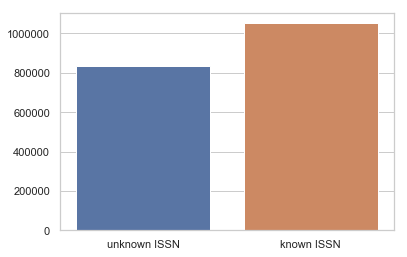

In [72]:
sns.set(style="whitegrid")
ax = sns.barplot(data=ISSN_counts.transpose())